가설2: 디커플링 → 신용경색 Granger 시작
디커플링 데이터 확인


,date,gap
0,2005-01-01,1.745656
1,2005-02-01,1.364802
2,2005-03-01,0.846905
3,2005-04-01,1.296759
4,2005-05-01,0.773001


스프레드 데이터 확인


,date,SPREAD
0,2004-01-01,0.79
1,2004-02-01,0.80
2,2004-03-01,0.79
3,2004-04-01,0.75
4,2004-05-01,0.68


병합 결과


,date,gap,SPREAD
0,2005-01-01,1.745656,0.46
1,2005-02-01,1.364802,0.44
2,2005-03-01,0.846905,0.44
3,2005-04-01,1.296759,0.42
4,2005-05-01,0.773001,0.41



📈 시각화 1) 디커플링(gap) vs 신용스프레드(원시)


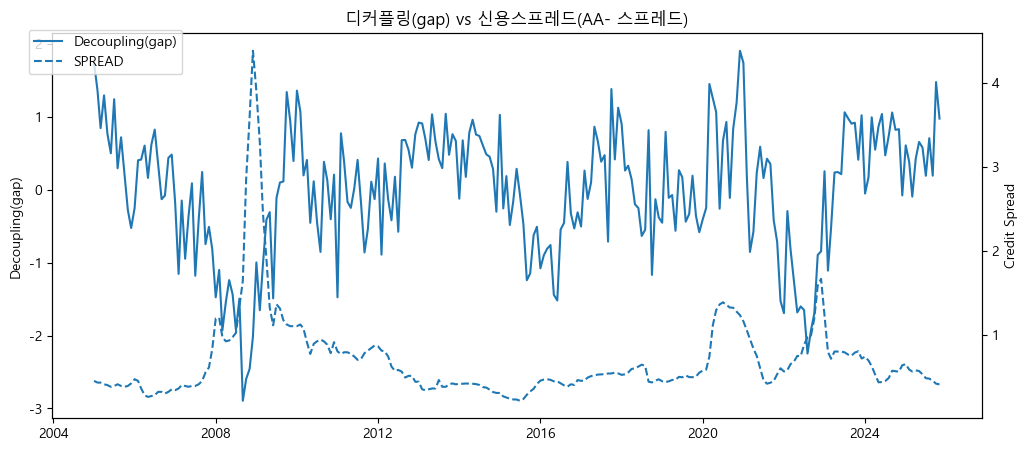

차분 후 데이터


,date,gap,SPREAD,DECOUPLING_d1,SPREAD_d1
0,2005-02-01,1.364802,0.44,-0.380854,-2.000000e-02
1,2005-03-01,0.846905,0.44,-0.517897,8.881784e-16
2,2005-04-01,1.296759,0.42,0.449855,-2.000000e-02
3,2005-05-01,0.773001,0.41,-0.523758,-1.000000e-02
4,2005-06-01,0.502169,0.39,-0.270832,-2.000000e-02



📈 시각화 2) 차분(d1) 시계열 비교


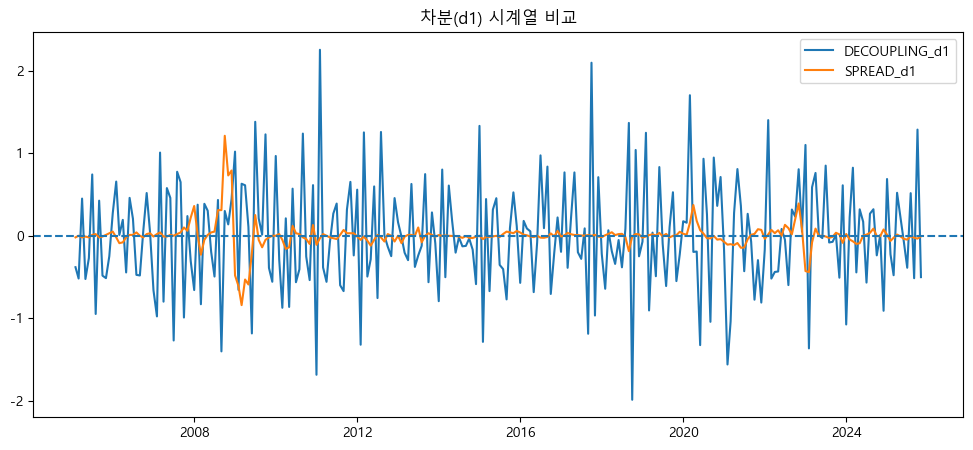

디커플링 → 스프레드

DECOUPLING_d1 → SPREAD_d1 (maxlag=6)


c:\anaconda\envs\data\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,lag,p_value
0,1,0.023374
1,2,0.038510
2,3,0.021825
3,4,0.045772
4,5,0.038892
5,6,0.065490


최소 p-value: 0.0218 (lag3)

📈 시각화 3) Granger lag별 p-value (ssr F-test)


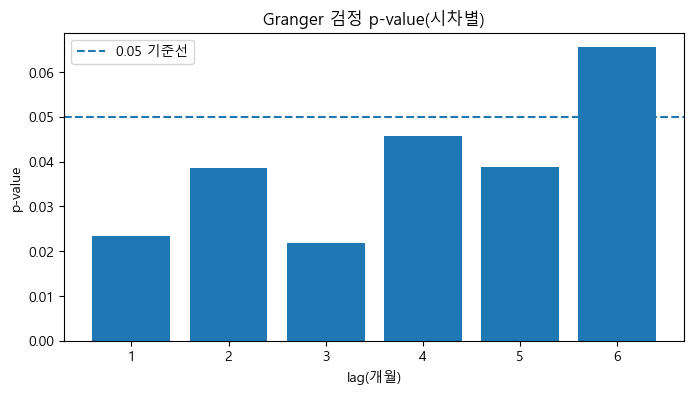


📈 시각화 4) 대표 시차 산점도 (lag=3)


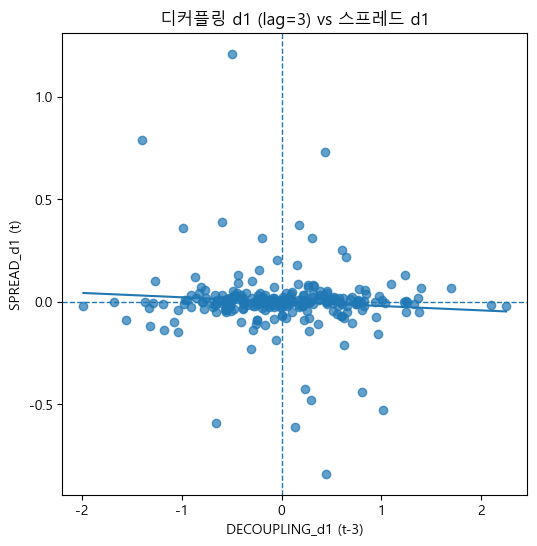


가설2 Granger 완료 ✅


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from IPython.display import display

# 한글 설정(경고 없이)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

print("가설2: 디커플링 → 신용경색 Granger 시작")

# ===============================
# 1. 디커플링 로드 + 월 평균 처리
# ===============================
PATH_DECOUPLING = "../../윤성/data/decoupling.csv"
df_dec = pd.read_csv(PATH_DECOUPLING)

df_dec["date"] = pd.to_datetime(df_dec["date"], errors="coerce")
df_dec = df_dec.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# ✅ gap 컬럼이 없으면 fin-real로 생성(안전장치)
if "gap" not in df_dec.columns:
    if ("fin_index" in df_dec.columns) and ("real_index" in df_dec.columns):
        df_dec["gap"] = pd.to_numeric(df_dec["fin_index"], errors="coerce") - pd.to_numeric(df_dec["real_index"], errors="coerce")
    else:
        raise ValueError("decoupling 파일에서 'gap' 또는 ('fin_index','real_index')를 찾을 수 없습니다.")

df_dec["gap"] = pd.to_numeric(df_dec["gap"], errors="coerce")
df_dec = df_dec.dropna(subset=["gap"])

df_dec = df_dec.groupby("date", as_index=False)["gap"].mean()
df_dec = df_dec.sort_values("date").reset_index(drop=True)

print("디커플링 데이터 확인")
display(df_dec.head())

# ===============================
# 2. 신용스프레드 로드
# ===============================
PATH_SPREAD = "../data/전처리_신용스프레드.csv"
df_sp = pd.read_csv(PATH_SPREAD)

# 날짜 컬럼 자동 탐색
date_col = [c for c in df_sp.columns if "date" in c.lower() or "기간" in c or "시점" in c][0]
df_sp = df_sp.rename(columns={date_col: "date"})
df_sp["date"] = pd.to_datetime(df_sp["date"], errors="coerce")

# 스프레드 컬럼 자동 탐색
val_col = [c for c in df_sp.columns if c != "date"][0]
df_sp = df_sp[["date", val_col]].rename(columns={val_col: "SPREAD"})
df_sp["SPREAD"] = pd.to_numeric(df_sp["SPREAD"], errors="coerce")
df_sp = df_sp.dropna(subset=["date", "SPREAD"]).sort_values("date").reset_index(drop=True)

print("스프레드 데이터 확인")
display(df_sp.head())

# ===============================
# 3. 병합 (월 기준 유지)
# ===============================
df = df_dec.merge(df_sp, on="date", how="inner")
df = df.sort_values("date").reset_index(drop=True)

print("병합 결과")
display(df.head())

# ===============================
# ✅ (시각화 1) 원시 시계열(이중축): gap vs spread
# ===============================
print("\n📈 시각화 1) 디커플링(gap) vs 신용스프레드(원시)")

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(df["date"], df["gap"], label="Decoupling(gap)")
ax1.set_ylabel("Decoupling(gap)")

ax2 = ax1.twinx()
ax2.plot(df["date"], df["SPREAD"], label="SPREAD", linestyle="--")
ax2.set_ylabel("Credit Spread")

ax1.set_title("디커플링(gap) vs 신용스프레드(AA- 스프레드)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()

# ===============================
# 4. 정상성 확보 (1차 차분)
# ===============================
df["DECOUPLING_d1"] = df["gap"].diff()
df["SPREAD_d1"] = df["SPREAD"].diff()
df = df.dropna().reset_index(drop=True)

print("차분 후 데이터")
display(df.head())

# ===============================
# ✅ (시각화 2) 차분 시계열 비교
# ===============================
print("\n📈 시각화 2) 차분(d1) 시계열 비교")

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["DECOUPLING_d1"], label="DECOUPLING_d1")
plt.plot(df["date"], df["SPREAD_d1"], label="SPREAD_d1")
plt.axhline(0, linestyle="--")
plt.title("차분(d1) 시계열 비교")
plt.legend()
plt.show()

# ===============================
# 5. Granger 인과검정
# ===============================
def run_granger(df, cause, effect, maxlag=6):
    data = df[[effect, cause]].dropna()

    print("\n" + "="*60)
    print(f"{cause} → {effect} (maxlag={maxlag})")
    print("="*60)

    res = grangercausalitytests(data, maxlag=maxlag, verbose=False)
    pvals = {lag: res[lag][0]["ssr_ftest"][1] for lag in res.keys()}

    out = pd.DataFrame({
        "lag": list(pvals.keys()),
        "p_value": list(pvals.values())
    }).sort_values("lag")

    display(out)

    best_lag = out.loc[out["p_value"].idxmin(), "lag"]
    best_p = out["p_value"].min()
    print(f"최소 p-value: {best_p:.4f} (lag{int(best_lag)})")

    return out

print("디커플링 → 스프레드")
p_table = run_granger(df, "DECOUPLING_d1", "SPREAD_d1", maxlag=6)

# ===============================
# ✅ (시각화 3) lag별 p-value 바차트
# ===============================
print("\n📈 시각화 3) Granger lag별 p-value (ssr F-test)")

plt.figure(figsize=(8,4))
plt.bar(p_table["lag"], p_table["p_value"])
plt.axhline(0.05, linestyle="--", label="0.05 기준선")
plt.xticks(p_table["lag"])
plt.title("Granger 검정 p-value(시차별)")
plt.xlabel("lag(개월)")
plt.ylabel("p-value")
plt.legend()
plt.show()

# ===============================
# ✅ (시각화 4) 대표 시차(lag=3) 산점도 + 단순회귀선(직관용)
#     ※ Granger 자체는 시차 전체를 보지만, 결과 설명용으로 '최소 p' lag를 시각화
# ===============================
best_lag = int(p_table.loc[p_table["p_value"].idxmin(), "lag"])
print(f"\n📈 시각화 4) 대표 시차 산점도 (lag={best_lag})")

tmp = df.copy()
tmp["dec_lag"] = tmp["DECOUPLING_d1"].shift(best_lag)
tmp = tmp.dropna(subset=["dec_lag", "SPREAD_d1"])

plt.figure(figsize=(6,6))
plt.scatter(tmp["dec_lag"], tmp["SPREAD_d1"], alpha=0.7)
# 단순 회귀선(시각화 목적)
m, b = np.polyfit(tmp["dec_lag"], tmp["SPREAD_d1"], 1)
x_line = np.linspace(tmp["dec_lag"].min(), tmp["dec_lag"].max(), 100)
plt.plot(x_line, m*x_line + b)
plt.axhline(0, linestyle="--", linewidth=1)
plt.axvline(0, linestyle="--", linewidth=1)
plt.title(f"디커플링 d1 (lag={best_lag}) vs 스프레드 d1")
plt.xlabel(f"DECOUPLING_d1 (t-{best_lag})")
plt.ylabel("SPREAD_d1 (t)")
plt.show()

print("\n가설2 Granger 완료 ✅")
